# Opening ZIP files for 2006-2014


ashley: 2006-2007

emily: 2008-2009

lorraine: 2010-2011

ethan: 2012-2013

christopher: 2014


In [ ]:
import os
import zipfile

In [ ]:
# Mounting Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to your zip file
zip_path = '/content/drive/MyDrive/Data/Plankton/2014.zip' # CHANGE THIS

# Extract to the same directory as the zip file
extract_path = '/content/drive/MyDrive/Data/Plankton/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Successfully extracted to {extract_path}")

# Data cleaning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # uncomment to disable GPU
import tensorflow as tf
from tensorflow import keras

In [ ]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)


In [ ]:

data_dir = "/content/drive/MyDrive/Plankton/WHOI_unzipped_data"

In [ ]:
def png_filenames(year, data_dir, exclude_list=None):
    dir_name = os.path.join(data_dir, str(year))

    # find all png files
    png_files = !find "{dir_name}" -name "*.png"
    png_files = np.array(png_files)

    # exclude list
    if exclude_list is None:
        exclude_list = ['mix', 'mix_elongated', 'detritus', 'bad']
    exclude_list = np.array(exclude_list)

    # extract class names from folder structure
    class_name = np.array([
        f.replace(dir_name + '/', '').split('/', 1)[0]
        for f in png_files
    ])

    # filter out unwanted classes
    mask = ~np.isin(class_name, exclude_list)
    png_files = png_files[mask]
    class_name = class_name[mask]

    return png_files, class_name


In [ ]:
years = [2013, 2014]

all_files = []
all_labels = []

for year in years:
    files, labels = png_filenames(year, data_dir)
    all_files.extend(files)
    all_labels.extend(labels)

all_files = np.array(all_files)
all_labels = np.array(all_labels)

print("Classes:", np.unique(all_labels))
print("Number of images:", len(all_files))
print("Images by classes:", np.unique(all_labels, return_counts=True))


KeyboardInterrupt: 

In [ ]:
#extract png file paths for a range of years

class_name=np.array([])
png_names=np.array([])
for year in np.arange(2013, 2014): # data available 2006-2014
        print(year)
        a, b = png_filenames(year,data_dir)
        png_names=np.concatenate((png_names, a), axis=0)    #concatenate the data from different years
        class_name=np.concatenate((class_name, b), axis=0)

TypeError: Cannot interpret '2014' as a data type

In [ ]:
classes, counts = np.unique(class_name, return_counts=True)               # identify the unique classes and associated number of examples
classes_sorted=[x for y, x in sorted(zip(counts,classes),reverse=True)]   # sort classes by the number of examples
counts_sorted=sorted(counts,reverse=True)

Let's take a look at how many images we have for different species':

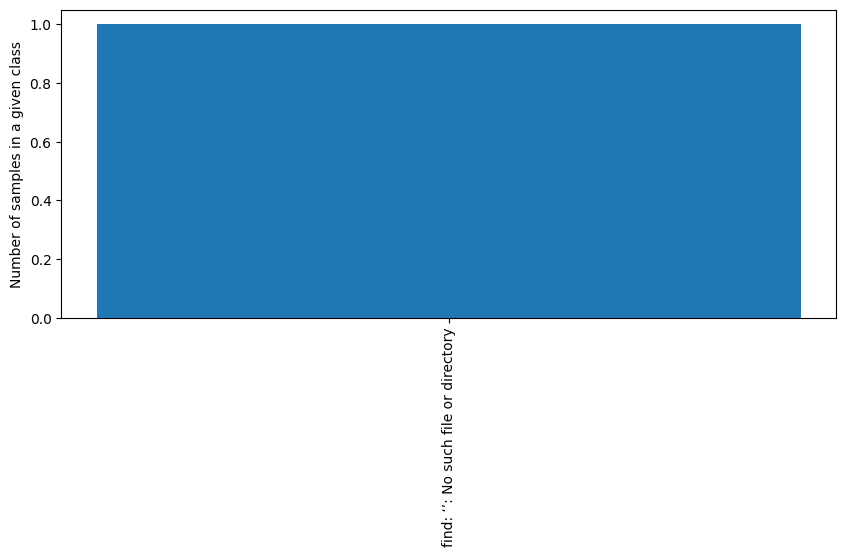

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(classes_sorted[:20], counts_sorted[:20]) #plot top 10 most observed classes
plt.xticks(rotation='vertical')
plt.ylabel('Number of samples in a given class');

Let's take a look at some of those images, run this cell to see 3 random images from the data set:

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (12,8))
for i in range(3):
    N=np.random.randint(len(png_names))
    im=image.imread(png_names[N])
    axs[i].imshow(im, cmap = 'gray', vmin = 0, vmax = 1) # the black and white images have pixel values ranging from 0 (black) to 1 (white)
    axs[i].set_title(class_name[N]);

One thing that jumps out straight away is that the images come in very different shapes and sizes. The deep learning model we'll build later requires fixed inputs which aren't too large (to limit the memory requirements during training). To do this, let's take a square cropped image from the center of each image with fixed size, say, 64 pixels. If either dimension of the image is less than 64 we'll pad the image with zeros (i.e. black pixels)

In [ ]:
#crop only the center n by n pixel image from the original data, and fill the image to an n by n size if it is smaller than that
def crop_center(im,n):

    nx=im.shape[1]
    ny=im.shape[0]

    if nx<n:
        imm=np.zeros((ny,n))
        imm[:ny,:nx]=im
        im=imm

    nx=im.shape[1]
    ny=im.shape[0]

    if ny<n:
        imm=np.zeros((n,nx))
        imm[:ny,:nx]=im
        im=imm

    nx=im.shape[1]
    ny=im.shape[0]

    im=im[ (ny//2-n//2):(ny//2+n//2),(nx//2-n//2):(nx//2+n//2)]

    return im

Let's see how those cropped images look...

In [ ]:
fig, axs = plt.subplots(5,2, figsize = (7,12))
for i in range(5):
    N=np.random.randint(len(png_names))
    im=image.imread(png_names[N])
    axs[i][0].imshow(im, cmap = 'gray', vmin = 0, vmax = 1)
    im=crop_center(im,64)
    axs[i][1].imshow(im, cmap = 'gray', vmin = 0, vmax = 1)
    axs[i][0].set_title(class_name[N]);

We definitely lose some information by taking these small crops from the images, but there should hopefully still be enough distinctive features within the cropped images for our deep learning model to recognise the species!

Now that we've explored the data a little, let's go ahead and load in lots of images (extracting square crops from each) into numpy arrays.